# Demo

The purpose of this notebook is to provide a concrete example of how the approach described [here]() can be implemented. 

## Preamble

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

from bert.utils import obtain_sentence_embeddings
from extractor.train import convert_training_dict
from pytorch_transformers import BertModel
from pytorch_transformers import BertTokenizer
from torch import nn

BERT_OUTPUT_SIZE = 768
BI_LSTM_OUTPUT_SIZE = 8
START_OF_SENTENCE_TOKEN = "[CLS]"
END_OF_SENTENCE_TOKEN = "[SEP]"

## Helper Functions

In [2]:
nll_loss = torch.nn.NLLLoss()

def freeze_weights(model):
    for param in model.parameters():
        param.requires_grad = False
            
def obtain_sentence_embedding(model, tokenizer, input_sentence):
    input_sentence = torch.tensor(
        tokenizer.encode(f"{START_OF_SENTENCE_TOKEN} {input_sentence} {END_OF_SENTENCE_TOKEN}")
    ).unsqueeze(0)
    last_hidden_state, pooler_output = model(input_sentence)
    last_hidden_state = last_hidden_state.squeeze()
    cls_embedding = last_hidden_state[0].view(1, -1)

    return cls_embedding

def cross_entropy_loss(prob, target):
    log_prob = torch.log(prob)
    loss = nll_loss(log_prob, target)
    return loss

## Load Data

Obtains a sample document to train on

In [3]:
# Obtain pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
freeze_weights(bert_model)

In [4]:
# Load articles and labels
data = pickle.load(open('data/development_data/training_dictionaries.pkl', 'rb'))

# Get a sample document
document = data[0]['document']
extraction_label = data[0]['extraction_label']
n_ext_sents = extraction_label.sum().int()

# Peak
print(f"SAMPLE ARTICLE: \n{' '.join(document)}\n ")
ext_sents = np.array(document)[extraction_label.bool().numpy()].tolist()
print(f"EXTRACTION SENTENCES (LABELS): \n{' '.join(ext_sents)}")

SAMPLE ARTICLE: 
( cnn ) share , and your gift will be multiplied . that may sound like an esoteric adage , but when zully broussard selflessly decided to give one of her kidneys to a stranger , her generosity paired up with big data . it resulted in six patients receiving transplants . that surprised and wowed her . " i thought i was going to help this one person who i do n't know , but the fact that so many people can have a life extension , that 's pretty big , " broussard told cnn affiliate kgo . she may feel guided in her generosity by a higher power . " thanks for all the support and prayers , " a comment on a facebook page in her name read . " i know this entire journey is much bigger than all of us . i also know i 'm just the messenger . " cnn can not verify the authenticity of the page . but the power that multiplied broussard 's gift was data processing of genetic profiles from donor - recipient pairs . it works on a simple swapping principle but takes it to a much higher lev

## Create Models

In [5]:
bi_lstm = nn.LSTM(
    input_size=BERT_OUTPUT_SIZE,
    hidden_size=BI_LSTM_OUTPUT_SIZE,
    num_layers=1,
    bidirectional=True,
    batch_first=True
)

ptr_lstm = nn.LSTM(
    input_size=BI_LSTM_OUTPUT_SIZE * 2,
    hidden_size=BI_LSTM_OUTPUT_SIZE * 2,
    num_layers=1,
    bidirectional=False,
    batch_first=True
)
softmax = torch.nn.Softmax(-1)

## Training

Loss: 3.5412235260009766


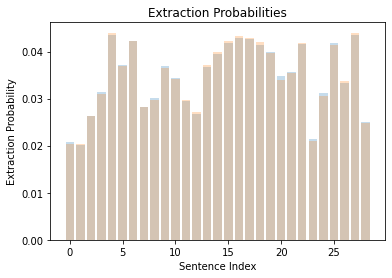

Loss: 1.2064175605773926


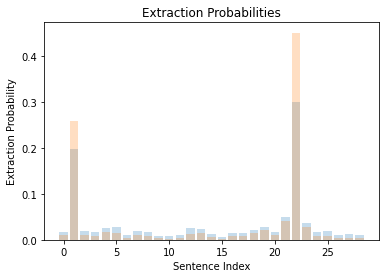

Loss: 0.298395037651062


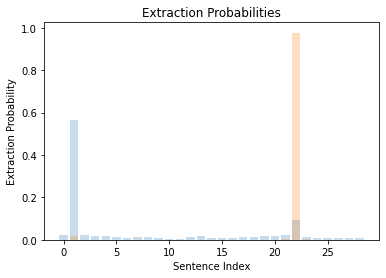

Loss: 0.2227761298418045


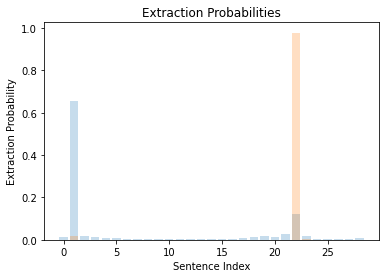

Loss: 0.11345800757408142


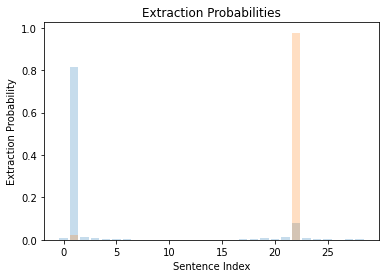

Loss: 0.037269704043865204


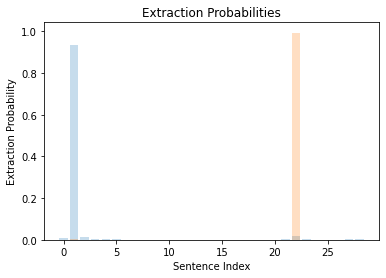

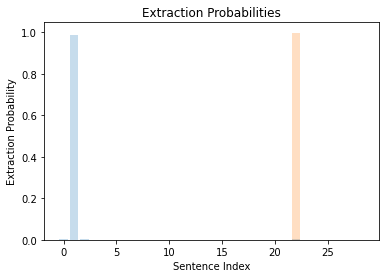

In [6]:
# Obtain bert sentence embeddings
bert_sent_embeddings = [obtain_sentence_embedding(bert_model, bert_tokenizer, sentence) for sentence in document]
bert_sent_embeddings = torch.cat(bert_sent_embeddings).unsqueeze(0)

# Randomly initialize initial input embedding:
rand_floats = torch.FloatTensor(1, BI_LSTM_OUTPUT_SIZE * 2).uniform_(-1, 1) * 1e-1
init_sent_embedding = torch.nn.Parameter(rand_floats, requires_grad=True)

# Hyper parameters
learning_rate = 1e-3
n_training_iters = 300
model_params = list(bi_lstm.parameters()) + list(ptr_lstm.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# Training iterations
for iteration_idx in range(n_training_iters):
    bi_lstm_hidden_state, __ = bi_lstm(bert_sent_embeddings)
    input_embedding = init_sent_embedding.unsqueeze(0) 
    init_hidden_cell_state = None
    extraction_probs = list()

    for i in range(n_ext_sents):
        # Obtain context
        ptr_hidden_state, init_hidden_cell_state = ptr_lstm(input_embedding, init_hidden_cell_state)
        attn_values = torch.bmm(ptr_hidden_state, bi_lstm_hidden_state.transpose(1, 2))
        self_attn_weights = softmax(attn_values)
        context = torch.bmm(self_attn_weights, bi_lstm_hidden_state)

        # Obtain extraction probability
        attn_values = torch.bmm(context, bi_lstm_hidden_state.transpose(1, 2))
        extraction_prob = softmax(attn_values)
        extraction_probs.append(extraction_prob)

        # Obtain next input embedding
        ext_sent_idx = torch.argmax(extraction_prob)
        input_embedding = bi_lstm_hidden_state[0:1, ext_sent_idx:ext_sent_idx+1, :]

    # Calculate loss
    y_hat = torch.cat(extraction_probs).squeeze()
    y = torch.where(extraction_label)[0]
    loss = cross_entropy_loss(prob=y_hat, target=y)
    if iteration_idx % 50 == 0:
        print(f'Loss: {loss}')
        plt.bar(range(y_hat[0].shape[0]), y_hat[0].data.numpy(), alpha=0.25)
        plt.bar(range(y_hat[1].shape[0]), y_hat[1].data.numpy(), alpha=0.25)
        plt.title('Extraction Probabilities')
        plt.xlabel('Sentence Index')
        plt.ylabel('Extraction Probability')
        plt.show()

    # Update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

plt.bar(range(y_hat[0].shape[0]), y_hat[0].data.numpy(), alpha=0.25)
plt.bar(range(y_hat[1].shape[0]), y_hat[1].data.numpy(), alpha=0.25)
plt.title('Extraction Probabilities')
plt.xlabel('Sentence Index')
plt.ylabel('Extraction Probability')
plt.show()

In [13]:
self_attn_weights.shape

torch.Size([1, 1, 29])

In [7]:
print(f'Target indicies: {y}')
print(f'Extracted indicies: {torch.argmax(y_hat, -1)}')
print(f'Extraction probabilities: {y_hat[:, extraction_label.bool()].diag()}')

Target indicies: tensor([ 1, 22])
Extracted indicies: tensor([ 1, 22])
Extraction probabilities: tensor([0.9897, 0.9983], grad_fn=<DiagBackward>)


The above has been over-trained but demonstrates how the extraction approach works